In [20]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# construct_training_set = True
construct_training_set = False

# use_cloudaugment = True
use_cloudaugment = False

# create U-Net folder
unet_model_dir = Path("../cloud_seg/models/unet/")
unet_model_dir.mkdir(parents=True, exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Things to add
# https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_cli.html

### Model training script

In [22]:
%%file ../scripts/train_unet.py

import shutil
import numpy as np
import pandas as pd
import pandas_path as path
from PIL import Image
import torch
import pytorch_lightning as pl
import glob
from pathlib import Path
import argparse
import os
import datetime

from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.plugins import DDPPlugin
import albumentations as A

from cloud_seg.models.unet.cloud_model import CloudModel
from cloud_seg.utils.augmentations import CloudAugmentations

import matplotlib.pyplot as plt

DATA_DIR = Path.cwd().parent.resolve() / "data/"
DATA_DIR_MODEL_TRAINING = DATA_DIR / "model_training/"
DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/tif/'
DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'

TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_FEATURES_NEW = DATA_DIR / "train_features_new"

TRAIN_LABELS = DATA_DIR / "train_labels"

band_mean_std = np.load(DATA_DIR / 'measured_band_stats.npy', allow_pickle=True).item()

def none_or_str(value):
    if value == 'None':
        return None
    return value

def main(args):
    # train_data_string = ""   
    # train_data_string = "_new"
    
    hparams = vars(args)
    if hparams['verbose']: print("Parameters are: ", hparams)

    pl.seed_everything(hparams['seed'], workers=True)
    hparams['precision'] = 32
    hparams['bands_use'] = sorted(hparams['bands'] + hparams['bands_new']) if hparams['bands_new'] is not None else hparams['bands']
    
    # hparams['band_means'] = [band_mean_std[i]['mean'] for i in hparams['bands_use']]
    # hparams['band_stds'] = [band_mean_std[i]['std'] for i in hparams['bands_use']]
    # hparams['max_pixel_value'] = 1.0
    # if hparams['custom_feature_channels'] == "true_color":
    #     hparams['bands_use'] = ['B04', 'B03', 'B02']
    #     hparams['band_means'] = [0.485, 0.456, 0.406] # imagenet for now
    #     hparams['band_stds'] = [0.229, 0.224, 0.225]      
    #     hparams['max_pixel_value'] = 255


    hparams['OUTPUT_DIR'] = os.path.join(hparams['OUTPUT_DIR'], hparams['segmentation_model'])
    Path(hparams['OUTPUT_DIR']).mkdir(parents=True, exist_ok=True)

    # Set up transforms using Albumentations library
    Augs = CloudAugmentations(hparams)
    train_transforms, train_transforms_names = Augs.add_augmentations()
    train_transforms = A.Compose(train_transforms)

    augs_val = 'nr' if 'Normalize' in train_transforms_names else ''
    val_transforms, val_transforms_names = Augs.add_augmentations(augs_val)
    val_transforms = A.Compose(val_transforms)

    print("Train, val transforms: ", train_transforms_names, val_transforms_names)
    
    train_cloud_transforms = None
    if hparams['cloud_augment']:
        # Set up transforms using Albumentations library
        hparams_cloud = hparams.copy()
        hparams_cloud['sigma_brightness'] = hparams['cloud_sigma_brightness']
        hparams_cloud['mean_brightness'] = hparams['cloud_mean_brightness']
        hparams_cloud['uniform_brightness'] = hparams['cloud_uniform_brightness']
        hparams_cloud['min_max_crop'] = hparams['cloud_min_max_crop']

        Augs = CloudAugmentations(hparams_cloud)
        
        train_cloud_transforms, train_cloud_transforms_names = Augs.add_augmentations(hparams['cloud_augmentations'])
        train_cloud_transforms = A.Compose(train_cloud_transforms)
        print("train cloud transforms: ", train_cloud_transforms_names)
        
    val_cloud_transforms = None
    if hparams['cloud_augment_val']:
        # Set up transforms using Albumentations library
        hparams_val_cloud = hparams.copy()
        hparams_val_cloud['aug_prob_soft'] = 1.0
        Augs = CloudAugmentations(hparams_val_cloud)
        
        val_cloud_transforms, val_cloud_transforms_names = Augs.add_augmentations(hparams_val_cloud['cloud_augmentations_val'])
        val_cloud_transforms = A.Compose(val_cloud_transforms)
        print("val cloud transforms: ", val_transforms_names)
        
    # set up logger and model outputs to have meaningful name

    dataset_str = 'originaldata'
    if hparams['cloud_augment']:
        dataset_str += '_cloudaugment'
    curent_time = datetime.datetime.now().strftime("%Y-%m-%d")#-%H:%M:%S")
 
    model_out_name = f"{len(hparams['bands_use'])}band"
    model_out_name += f"_{dataset_str}"  
    model_out_name += f"_{hparams['encoder_name']}"
    model_out_name += f"_{hparams['loss_function']}"
    model_out_name += f"_{hparams['augmentations']}"
    model_out_name += f"_customfeats_{hparams['scale_feature_channels']}"
    # model_out_name += f"_depth{hparams['encoder_depth']}"
    model_out_name += f"_{curent_time}"
    model_out_name += f"_cv{hparams['cross_validation_split']}"

    hparams['model_training_name'] = model_out_name
    if hparams['test_run']:
        model_training_name = 'test'
    
    hparams['LOG_DIR'] = os.path.join(hparams['OUTPUT_DIR'], hparams['model_training_name'], hparams['LOG_DIR'])
    hparams['MODEL_DIR'] = os.path.join(hparams['OUTPUT_DIR'], hparams['model_training_name'], hparams['MODEL_DIR'])
                                      
    Path(hparams['LOG_DIR']).mkdir(parents=True, exist_ok=True)
    Path(hparams['MODEL_DIR']).mkdir(parents=True, exist_ok=True)
    
    # Load Data
    val_x = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_features_meta_cv{hparams['cross_validation_split']}.csv")
    val_y = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_labels_meta_cv{hparams['cross_validation_split']}.csv")
    
    # shuffle validation, such that each batch will have samples from different locations,
    # as validation_dataloader has shuffle=False
    val_x = val_x.sample(frac=1, random_state=42).reset_index(drop=True)
    val_y = val_y.sample(frac=1, random_state=42).reset_index(drop=True)
    
    if hparams['verbose']: print(val_y.head())
    
    train_x = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_features_meta_cv{hparams['cross_validation_split']}.csv")
    train_y = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_labels_meta_cv{hparams['cross_validation_split']}.csv")

    train_cloudbank = None
    if hparams['cloud_augment']:

        train_x_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_features_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
        train_y_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_labels_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
        
        train_x_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_features_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
        train_y_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_labels_cloudless_meta_cv{hparams['cross_validation_split']}.csv")

        # duplicate cloudless chips
        for i in range(1):
            train_y = train_y.append(train_y_cloudless, ignore_index=True)
            train_x = train_x.append(train_x_cloudless, ignore_index=True)

        train_cloudbank = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_cloudbank_meta_cv{hparams['cross_validation_split']}.csv")

    val_cloudbank = None
    if hparams['cloud_augment']:

        val_x_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_features_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
        val_y_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_labels_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
        
        val_x_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_features_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
        val_y_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_labels_cloudless_meta_cv{hparams['cross_validation_split']}.csv")

        # duplicate cloudless chips
        for i in range(1):
            val_y = val_y.append(train_y_cloudless, ignore_index=True)
            val_x = val_x.append(train_x_cloudless, ignore_index=True)

        val_cloudbank = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_cloudbank_meta_cv{hparams['cross_validation_split']}.csv")

    if hparams['test_run']:
        nuse = hparams['test_run_nchips']

        train_x = train_x.iloc[:nuse]
        train_y = train_y.iloc[:nuse]

        val_x = val_x.iloc[:nuse]
        val_x = val_x.iloc[:nuse]

        train_cloudbank = train_cloudbank.iloc[:nuse] if df_cloudbank is not None else None
        val_cloudbank = val_cloudbank.iloc[:nuse] if df_cloudbank is not None else None
        

    # Set up models and callbacks
    cloud_model = CloudModel(
        bands=hparams['bands_use'],
        x_train=train_x,
        y_train=train_y,
        x_val=val_x,
        y_val=val_y,
        train_cloudbank=train_cloudbank,
        val_cloudbank=val_cloudbank,
        train_transforms=train_transforms,
        val_transforms=val_transforms,
        train_cloud_transforms=train_cloud_transforms,
        val_cloud_transforms=val_cloud_transforms,
        hparams=hparams,
    )
        
    if hparams['load_checkpoint_path'] is not None:
        cloud_model = cloud_model.load_from_checkpoint(hparams['load_checkpoint_path'])
  
        
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=hparams['LOG_DIR'],
        name='log',
    )

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=hparams['MODEL_DIR'],
        filename="best_{epoch}-{val_iou:.4f}",
        monitor="val_iou",
        mode="max",
        verbose=True,
        save_last=True,
    )

    early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
        monitor="val_iou",
        patience=(cloud_model.patience * 3),
        mode="max",
        verbose=True,
    )

    lr_monitor = pl.callbacks.LearningRateMonitor(
        logging_interval='epoch'
    )

    # if hparams['strategy'] == 'ddp':
    #     strategy = DDPPlugin(find_unused_parameters=False)
    # else:
    #     strategy = hparams['strategy']

    strategy = hparams['strategy']

    # Train model
    # "ddp_spawn" needed for interactive jupyter, but best to use "ddp" if not
    trainer = pl.Trainer(
        gpus=-1,
        num_nodes=4,
        # deterministic=True,
        fast_dev_run=False,
        # profiler="simple",
        # max_epochs=2,
        # overfit_batches=1,
        # auto_scale_batch_size=True,
        check_val_every_n_epoch=1,
        num_sanity_val_steps=2,
        max_epochs=hparams['max_epochs'],
        precision=hparams['precision'],
        strategy=strategy,
        # plugins=DDPSpawnPlugin(find_unused_parameters=False),
        callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor],
        logger=tb_logger,
        auto_lr_find=True,
    )

    # Fit the model
    trainer.fit(model=cloud_model)
    
#     # tune learning rate
#     # trainer.fit(model=cloud_model)
#     # Run learning rate finder
#     lr_finder = trainer.tuner.lr_find(cloud_model)

#     # Results can be found in
#     print(lr_finder.results)

#     # Plot with
    
#     fig = lr_finder.plot(suggest=True)
#     plt.savefig("lr_tune.png")
#     fig.show()

#     # Pick point based on plot, or get suggestion
#     new_lr = lr_finder.suggestion() 
#     print(new_lr)
    
if __name__=='__main__':
    
    parser = argparse.ArgumentParser(description='runtime parameters')
    
    # Data and IO
    parser.add_argument("--bands", nargs='+' , default=["B02", "B03", "B04", "B08"],
                        help="bands desired")
    
    parser.add_argument("--bands_new", nargs='+', default=None,
                        help="additional bands to use beyond original four")
    
    parser.add_argument("-cv", "--cross_validation_split", type=int, default=0,
                        help="cross validation split to use for training") 

    parser.add_argument("--OUTPUT_DIR", type=str, default='../trained_models/',
                        help="Directory to save logs and trained models model")
                                      
    parser.add_argument("--LOG_DIR", type=str, default='logs/',
                        help="Sub-directory of OUTPUT_DIR to save logs")
    
    parser.add_argument("--MODEL_DIR", type=str, default='model/',
                        help="Sub-directory of OUTPUT_DIR to save logs")

    parser.add_argument("--seed", type=int , default=13579,
                        help="random seed for train test split")
   
    parser.add_argument("-v", "--verbose", action="store_true",
                        help="increase output verbosity")
   

    # Training (gpus, optimization, etc...)
    parser.add_argument("--gpu", action="store_true",
                        help="Use GPU")
    
    parser.add_argument("--strategy", type=str, default='ddp',
                        help="Distributed training strategy")
        
    parser.add_argument("--test_run", action="store_true",
                        help="Subsample training and validation data")
    
    parser.add_argument("--test_run_nchips", type=int, default=512,
                        help="Subsample training and validation data to this size")

    parser.add_argument("--num_workers", type=int, default=12,
                        help="number of data loader workers")
    
    parser.add_argument("--persistent_workers", action="store_false",
                        help="Persistent data loader workers")
    
    parser.add_argument("--batch_size", type=int, default=8,
                        help="Batch size for model training")
    
    parser.add_argument("--loss_function", type=str, default='bce',
                        help="loss_function to use", choices=['bce', 'dice', 'jaccard', 'focal'])
      
    parser.add_argument("-lr", "--learning_rate", type=float, default=2e-3,
                        help="Learning rate for model optimization")
    
    parser.add_argument("-wd", "--weight_decay", type=float, default=5e-4,
                        help="Learning rate for model optimization")
    
    parser.add_argument("--optimizer", type=str, default='ADAM',
                        help="Optimizer to use", choices=['ADAM', 'SGD', 'ADAMW'])
    
    parser.add_argument("--scheduler", type=str, default='plateau',
                        help="Learning rate scheduler to use", choices=['plateau', 'exponential', 'cosine'])
    
    parser.add_argument("--warmup_epochs", type=int, default=10,
                        help="Number of warmup epochs, linear from lr=0 to lr=lr")
    
    parser.add_argument("--max_epochs", type=int, default=50,
                        help="Max number of epochs for cosine scheduler")
                              
    parser.add_argument("--plot_validation_images", action="store_false",
                        help="Plot final batch to tensorboard")
                      
    # Models and Augmentations
    parser.add_argument("--segmentation_model", type=str, default='unet',
                        help="Encocoder architecture to use", choices=['unet', 'DeepLabV3Plus'])
  
    parser.add_argument("--encoder_name", type=str, default='resnet18',
                        help="Encocoder architecture to use", choices=['efficientnet-b0','efficientnet-b3','efficientnet-b5',
                                                                       'resnet18', 'resnet34', 'resnet50',
                                                                       'vgg19_bn', 'tu-xception65',
                                                                      'tu-efficientnetv2_m', 'tu-resnest200e'])
    
    parser.add_argument("--encoder_depth", type=int, default=5,
                        help="Encoder depth")
    
    parser.add_argument("--weights", type=none_or_str, default=None,
                        help="Pretrained_weights architecture to use")
    
    parser.add_argument("--decoder_attention_type", type=none_or_str, default=None,
                        help="Attention in decoder")
    
    parser.add_argument("--augmentations", type=str, default='vfhfrrtrrcgdbr',
                        help="training augmentations to use")
    
    parser.add_argument("--cloud_augmentations", type=str, default='vfhfrrtrrcgdelbr',
                        help="training augmentations to use for cloudmix")
    
    parser.add_argument("--cloud_augmentations_val", type=str, default='vfhf',
                        help="training augmentations to use for cloudmix")
                
    parser.add_argument("--cloud_augment", action="store_true",
                        help="Use cloud augmentation")
    
    parser.add_argument("--cloud_augment_val", action="store_true",
                        help="Use cloud augmentation")

    parser.add_argument("--aug_prob_soft", type=float, default=0.5,
                        help="Probability of performing simple rotation augmentations")
    
    parser.add_argument("--aug_prob_medium", type=float, default=0.8,
                        help="Probability of performing medium augmentations")
    
    parser.add_argument("--aug_prob_hard", type=float, default=0.5,
                        help="Probability of performing hard augmentations")

    parser.add_argument("--grid_distort_limit", type=float, default=0.3,
                        help="gd")

    parser.add_argument("--min_max_crop", nargs='+' , default=[341, 512],
                        help="bands desired")
    
    parser.add_argument("--sigma_brightness", type=float, default=0.1,
                        help="gd")
    
    parser.add_argument("--mean_brightness", type=float, default=1.0,
                        help="gd")
    
    parser.add_argument("--uniform_brightness", action='store_true',
                        help="Uniform draw rather than gaussian")
    
    parser.add_argument("--cloud_sigma_brightness", type=float, default=0.1,
                        help="gd")
    
    parser.add_argument("--cloud_mean_brightness", type=float, default=1.0,
                        help="gd")
    
    parser.add_argument("--cloud_uniform_brightness", action='store_true',
                        help="Uniform draw rather than gaussian")

    parser.add_argument("--cloud_min_max_crop", nargs='+' , default=[256, 512],
                        help="bands desired")
        
    parser.add_argument("--scale_feature_channels", type=str, default=None,
                        help="Transform from band values to others", choices=['feder_scale', 'true_color', 'log_bands', 'custom'])
    
    parser.add_argument("--custom_features", nargs='+' , default=["luminosity", "B02/B03", "B02/B04", "B02/B08", "B02/B11"],
                        help="bands desired")
    
    parser.add_argument("--load_checkpoint_path", type=str, default=None,
                        help="checkpoint path to initialize training from")

    parser.add_argument("--use_npy_labels", action='store_true',
                        help=".tif (uint8) .npy (float32) ") 
                  
    args = parser.parse_args()
    
    main(args)

Overwriting ../scripts/train_unet.py


In [18]:
np.random.seed(420)
np.random.choice(['Tuesday', 'Thursday'])

'Thursday'

In [26]:
# Prepare submission. Extract model weights and save
import shutil
import numpy as np
import pandas as pd
import pandas_path as path
from PIL import Image
import torch
import pytorch_lightning as pl
import glob
from pathlib import Path
import argparse
import os
import datetime
from pathlib import Path

from pytorch_lightning import loggers as pl_loggers
import albumentations as A

from cloud_seg.models.unet.cloud_model import CloudModel

import matplotlib.pyplot as plt

submission_dir = '../trained_models/submission_dir/'
submission_assets_dir = os.path.join(submission_dir, 'assets')
Path(submission_assets_dir).mkdir(parents=True, exist_ok=True)

cloud_model_src_loc = '../cloud_seg/models/unet/'

num_cross_validation_splits = 4

### V0
# checkpoint_path = '../trained_models/unet/4band_originaldata_cloudaugment_resnet34_jaccard_vfhfrrtrrc_customfeats_feder_scale_2022-01-27_cv0/model/epoch=42-val_iou_epoch=0.8919.ckpt'
# checkpoint_path = '../trained_models/unet/4band_originaldata_cloudaugment_resnet18_bce_vfhfrrtrrc_customfeats_feder_scale_2022-01-24/model/epoch=49-val_iou_epoch=0.8819.ckpt'
# checkpoint_path = '../trained_models/unet/5band_originaldata_cloudaugment_resnet34_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-01_cv0/model/epoch=106-val_iou=0.8874.ckpt'

# checkpoint_dir_head = '../trained_models/unet/4band_originaldata_cloudaugment_resnet34_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-01_cv'
# checkpoint_dir_head = '../trained_models/unet/4band_originaldata_cloudaugment_resnet34_jaccard_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-02_cv'
# checkpoint_dir_head = '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b3_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-03_cv'

# checkpoint_dir_head = '../trained_models/old/unet/4band_originaldata_cloudaugment_resnet34_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-04_cv'

### V1
# checkpoint_dir_head = '../trained_models/unet/4band_originaldata_cloudaugment_resnet34_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-04_cv'
# checkpoint_dir_head = '../trained_models/unet/4band_originaldata_cloudaugment_resnet34_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv'

# checkpoint_dir_head = '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_jaccard_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv'
checkpoint_dir_head = '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv'
checkpoint_paths = []
for icv in range(num_cross_validation_splits):
    checkpoint_paths.append(f"{checkpoint_dir_head}{icv}/model/best.ckpt")
print(checkpoint_paths)

# Copy all required python files
for f in glob.glob(cloud_model_src_loc+"*"):
    if os.path.isfile(f):
        shutil.copy(f, submission_dir) 
        
shutil.copy("../cloud_seg/utils/augmentations.py", submission_dir)
shutil.copy("../cloud_seg/utils/band_normalizations.py", submission_dir)


# Save weights and hparams
checkpoint = torch.load(checkpoint_paths[0]) # assume all cross validation splits are same training/architecture
hparams = checkpoint['hyper_parameters']
hparams['augmentations'] = ''
hparams['batch_size'] = 8
hparams['num_workers'] = 4
hparams['weights'] = None
hparams['num_cross_validation_splits'] = num_cross_validation_splits
hparams['use_features'] = False # USE BOOSTED MODEL ALONGSIDE UNET

hparams['x_train'] = None
hparams['y_train'] = None
hparams['x_val'] = None
hparams['y_val'] = None
hparams['cloudbank'] = None
hparams['train_cloudbank'] = None
hparams['val_cloudbank'] = None
hparams['hparams'] = None
hparams['train_transforms'] = None
hparams['val_transforms'] = None
hparams['cloud_transforms'] = None

np.save(os.path.join(submission_assets_dir, "hparams.npy"), hparams)
    
for icv in range(num_cross_validation_splits):

    cloud_model = CloudModel.load_from_checkpoint(checkpoint_paths[icv])
    torch.save(cloud_model.state_dict(), os.path.join(submission_assets_dir, f"cloud_model_cv{icv}.pt"))

print("Done")
hparams

['../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv0/model/best.ckpt', '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv1/model/best.ckpt', '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv2/model/best.ckpt', '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv3/model/best.ckpt']
Done


{'bands': ['B02', 'B03', 'B04', 'B08'],
 'bands_new': None,
 'cross_validation_split': 0,
 'OUTPUT_DIR': '../trained_models/unet',
 'LOG_DIR': '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv0/logs/',
 'MODEL_DIR': '../trained_models/unet/4band_originaldata_cloudaugment_efficientnet-b5_bce_vfhfrrtrrcgdbr_customfeats_feder_scale_2022-02-05_cv0/model/',
 'seed': 0,
 'verbose': True,
 'gpu': False,
 'strategy': 'ddp',
 'test_run': False,
 'test_run_nchips': 512,
 'num_workers': 4,
 'persistent_workers': True,
 'batch_size': 8,
 'loss_function': 'bce',
 'learning_rate': 0.002,
 'weight_decay': 0.0001,
 'optimizer': 'ADAMW',
 'scheduler': 'cosine',
 'warmup_epochs': 10,
 'max_epochs': 100,
 'plot_validation_images': True,
 'segmentation_model': 'unet',
 'encoder_name': 'efficientnet-b5',
 'encoder_depth': 5,
 'weights': None,
 'decoder_attention_type': None,
 'augmentations': '',
 'cloud_augmentations': 'vfhfrrt

In [31]:
main_list = list(set(['B02', 'B03', 'B04', 'B08']) - set(['B02', 'B03', 'B04', 'B08']))
main_list == []


True

In [75]:
# %%file ../trained_models/submission_dir/main.py

import shutil
import numpy as np
import pandas as pd
import pandas_path as path
from PIL import Image
import torch
import pytorch_lightning as pl
import glob
from pathlib import Path
from loguru import logger

from typing import List
import typer
# import logging

import os
import argparse

import albumentations as A

try:
    from cloud_seg.models.unet.cloud_model import CloudModel
    from cloud_seg.models.unet.cloud_dataset import CloudDataset
    from cloud_seg.utils.augmentations import CloudAugmentations
except ImportError:
    from cloud_model import CloudModel
    from cloud_dataset import CloudDataset
    from augmentations import CloudAugmentations

if os.environ['CONDA_DEFAULT_ENV'] == 'cloud-seg':
    # running in local conda environment (hopefully theirs isnt the same name...)
    ROOT_DIR = Path("./")
    PREDICTIONS_DIR = ROOT_DIR / "predictions"
    ASSETS_DIR = ROOT_DIR / "assets"
    DATA_DIR = ROOT_DIR / "data"
    # INPUT_IMAGES_DIR = DATA_DIR / "test_features/"
    
else:
    ROOT_DIR = Path("/codeexecution")
    PREDICTIONS_DIR = ROOT_DIR / "predictions"
    ASSETS_DIR = ROOT_DIR / "assets"
    DATA_DIR = ROOT_DIR / "data"
    # INPUT_IMAGES_DIR = DATA_DIR / "test_features/"
    
    # Set the pytorch cache directory and include cached models in your submission.zip
    os.environ["TORCH_HOME"] = str(ASSETS_DIR / "assets/torch")


def get_metadata(features_dir: os.PathLike, hparams):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in hparams['bands_use']])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in sorted(chip_ids):
        # chip_bands = [INPUT_IMAGES_DIR / chip_id / f"{band}.tif" for band in bands]
        if hparams['bands_new'] is not None:
            chip_bands = [features_dir / chip_id / f"{band}.tif" if band not in hparams['bands_new'] else INPUT_IMAGES_DIR_NEW / chip_id / f"{band}.tif" for band in hparams['bands_use']] 
        else:
            chip_bands = [features_dir / chip_id / f"{band}.tif" for band in hparams['bands_use']] 

        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(
    model: CloudModel,
    x_paths: pd.DataFrame,
    hparams,
    predictions_dir: os.PathLike,
):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    # Set up transforms using Albumentations library
    Augs = CloudAugmentations(hparams)
    test_transforms, _transforms_names = Augs.add_augmentations()
    test_transforms = A.Compose(test_transforms)

    test_dataset = CloudDataset(
        x_paths=x_paths,
        bands=hparams['bands_use'],
        transforms=test_transforms,
        scale_feature_channels=model.scale_feature_channels,
    )
    
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=model.batch_size,
        num_workers=model.num_workers,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
    )
    
    torch.set_grad_enabled(False)
    model.eval()
    for batch_index, batch in enumerate(test_dataloader):
        print("Running on batch: ", batch_index)
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
       
        x = batch["chip"]
        if model.gpu:
            x = x.cuda(non_blocking=True)
        
        preds = model.forward(x)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5) * 1
        preds = preds.detach()
        
        if model.gpu:
            preds = preds.to("cpu")
            
        preds = preds.numpy()
        preds = preds.astype("uint8")

        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    model_weights_path = ASSETS_DIR / "cloud_model.pt",
    hparams_path = ASSETS_DIR / "hparams.npy",
    test_features_dir: Path = DATA_DIR / "test_features",
    predictions_dir: Path = PREDICTIONS_DIR,
    fast_dev_run: bool = False,
):
    """
    Generate predictions for the chips in features_dir using the model saved at
    model_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        model_weights_path (os.PathLike): Path to the weights of a trained CloudModel.
        features_dir (os.PathLike, optional): Path to the features for the data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
    """
    if not test_features_dir.exists():
        raise ValueError(
            f"The directory for feature images must exist and {test_features_dir} does not exist"
        )
    predictions_dir.mkdir(exist_ok=True, parents=True)

    logger.info("Loading model")
    
    hparams = np.load(hparams_path, allow_pickle=True).item()
    hparams['batch_size'] = 8
    hparams['weights'] = None
    # Load with gpu=False, then put on GPU
    hparams['gpu'] = False
    model = CloudModel(
        bands=hparams['bands_use'],
        hparams=hparams
    )

    model.load_state_dict(torch.load(model_weights_path))
    
    hparams['gpu'] = True
    if hparams['gpu']:
        model = model.cuda()
        model.gpu = True

             
    # Load metadata
    logger.info("Loading metadata")
    metadata = get_metadata(test_features_dir, hparams)
    if fast_dev_run:
        metadata = metadata.head()
    logger.info(f"Found {len(metadata)} chips")
    
    
    # Make predictions and save to disk
    logger.info("Generating predictions in batches")
    make_predictions(model, metadata, hparams, predictions_dir)

    logger.info(f"""Saved {len(list(predictions_dir.glob("*.tif")))} predictions""")


if __name__ == "__main__":
    typer.run(main)

Overwriting ../trained_models/submission_dir/main.py


In [76]:
%%file ../trained_models/submission_dir/test_submission.py
# from submission_dir.main import main 
from main import main

from pathlib import Path

submission_dir = Path('./')
TRAIN_FEATURES = Path('../../data/train_features/')

main(
    model_weights_path=submission_dir / "assets/cloud_model.pt",
    hparams_path = submission_dir / "assets/hparams.npy",
    test_features_dir=TRAIN_FEATURES,
    predictions_dir=submission_dir / "predictions",
    fast_dev_run=True,
)

Overwriting ../trained_models/submission_dir/test_submission.py


In [ ]:
!tree benchmark_src

# Zip submission
!cd unet_src && zip -r ../submission.zip *

!du -h submission.zip


# Model predict script

In [9]:
%%file ../scripts/predict_unet.py

import shutil
import numpy as np
import pandas as pd
import pandas_path as path
from PIL import Image
import torch
import pytorch_lightning as pl
import glob
from pathlib import Path

from typing import List
# import typer
import logging

import os
import argparse

import albumentations as A

from cloud_seg.models.unet.cloud_model import CloudModel
from cloud_seg.models.unet.cloud_dataset import CloudDataset
from cloud_seg.utils.augmentations import CloudAugmentations


parser = argparse.ArgumentParser(description='runtime parameters')
parser.add_argument("--bands", nargs='+' , default=["B02", "B03", "B04", "B08"],
                    help="bands desired")

parser.add_argument("--bands_new", nargs='+', default=None,
                    help="additional bands to use beyond original four")

parser.add_argument("-cv", "--cross_validation_split", type=int, default=0,
                    help="cross validation split to use for training") 

parser.add_argument("--batch_size", type=int, default=8,
                    help="Batch size for model inference")

parser.add_argument("--INPUT_DIR", type=str, default='../trained_models/unet/4band_originaldata_efficientnet-b0_dice__Normalize_VerticalFlip_HorizontalFlip_RandomRotate90/',
                    help="Directory to save logs and trained models model")

parser.add_argument("--LOG_DIR", type=str, default='logs/',
                    help="Sub-directory of OUTPUT_DIR to save logs")

parser.add_argument("--MODEL_DIR", type=str, default='model/',
                    help="Sub-directory of OUTPUT_DIR to save logs")

parser.add_argument("--OUTPUT_DIR", type=str, default='predictions/',
                    help="Directory to save logs and trained models model")

parser.add_argument("--gpu", action="store_true",
                    help="Use GPU")  
                    
parser.add_argument("-v", "--verbose", action="store_true",
                    help="increase output verbosity")
                    
parser.add_argument("--local_run", action="store_true",
                    help="Whether running locally or on planetary computer")
                    
parser.add_argument("--model_name", type=str, default='last.ckpt',
                    help="directory to save trained model")

parser.add_argument("--segmentation_model", type=str, default='unet',
                    help="Encocoder architecture to use", choices=['unet', 'DeepLabV3Plus'])
  
parser.add_argument("--encoder_name", type=str, default='resnet18',
                    help="Architecture to use", choices=['efficientnet-b0', 'efficientnet-b3', 'efficientnet-b5', 'resnet18', 'resnet34'])

parser.add_argument("--load_checkpoint", action="store_true",
                    help="Whether loading weights from checkpoint (.ckpt) or just from saved weights state_dict (.pt)")
    
parser.add_argument("--scale_feature_channels", type=str, default=None,
                    help="Transform from band values to others", choices=['feder_scale', 'true_color', 'log_bands', 'ratios'])

parser.add_argument("--augmentations", type=str, default='',
                        help="training augmentations to use")
    
hparams = vars(parser.parse_args())
hparams['weights'] = None
hparams['bands_use'] = sorted(hparams['bands'] + hparams['bands_new']) if hparams['bands_new'] is not None else hparams['bands']
         
# hparams['INPUT_DIR'] = os.path.join(hparams['INPUT_DIR'], hparams['segmentation_model'], hparams['model_training_name'])
# hparams['MODEL_DIR'] = os.path.join(hparams['INPUT_DIR'], hparams['model_training_name'], hparams['MODEL_DIR'])
# hparams['LOG_DIR'] = os.path.join(hparams['INPUT_DIR'], hparams['model_training_name'], hparams['OUTPUT_DIR'], hparams['LOG_DIR'])
# hparams['OUTPUT_DIR'] = os.path.join(hparams['INPUT_DIR'], hparams['model_training_name'], hparams['OUTPUT_DIR'])

# Path(hparams['LOG_DIR']).mkdir(parents=True, exist_ok=True)
# Path(hparams['OUTPUT_DIR']).mkdir(parents=True, exist_ok=True)

if hparams['local_run']:      
    
    ROOT_DIR = Path.cwd().parent.resolve()
    ASSETS_DIR = Path(hparams['INPUT_DIR'])
    MODEL_PATH = ASSETS_DIR / hparams['MODEL_DIR'] / hparams['model_name']
                    
    PREDICTIONS_DIR = ASSETS_DIR / hparams['OUTPUT_DIR']
     
    DATA_DIR = ROOT_DIR / "data/"
    DATA_DIR_MODEL_TRAINING = DATA_DIR / "model_training/"
    DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/tif/'
    DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'

    INPUT_IMAGES_DIR = DATA_DIR / "train_features"
    INPUT_IMAGES_DIR_NEW = DATA_DIR / "train_features_new"

    TRAIN_LABELS = DATA_DIR / "train_labels"

    band_mean_std = np.load(DATA_DIR / 'measured_band_stats.npy', allow_pickle=True).item()
       
    logger = logging.getLogger("test_logger")
    fh = logging.FileHandler('test_logger.log')
    ch = logging.StreamHandler()
    
    logger.addHandler(fh)
    logger.addHandler(ch)

    Path(PREDICTIONS_DIR).mkdir(parents=True, exist_ok=True)
  
else:
    ROOT_DIR = Path("/codeexecution")
    PREDICTIONS_DIR = ROOT_DIR / "predictions"
    ASSETS_DIR = ROOT_DIR / "assets"
                    
    DATA_DIR = ROOT_DIR / "data"
    INPUT_IMAGES_DIR = DATA_DIR / "test_features"
                    
    # Set the pytorch cache directory and include cached models in your submission.zip
    os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "assets/torch")

    MODEL_PATH = ASSETS_DIR / hparams['model_name']            

logger = logging.getLogger()

def get_metadata(bands: List[str]):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in INPUT_IMAGES_DIR.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in sorted(chip_ids):
        # chip_bands = [INPUT_IMAGES_DIR / chip_id / f"{band}.tif" for band in bands]
        if hparams['bands_new'] is not None:
            chip_bands = [INPUT_IMAGES_DIR / chip_id / f"{band}.tif" if band not in hparams['bands_new'] else INPUT_IMAGES_DIR_NEW / chip_id / f"{band}.tif" for band in bands] 
        else:
            chip_bands = [INPUT_IMAGES_DIR / chip_id / f"{band}.tif" for band in bands] 

        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(
    model: CloudModel,
    x_paths: pd.DataFrame,
    bands: List[str],
    predictions_dir: os.PathLike,
):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    # Set up transforms using Albumentations library
    Augs = CloudAugmentations(hparams)
    predict_transforms, _transforms_names = Augs.add_augmentations()
    predict_transforms = A.Compose(predict_transforms)

    predict_dataset = CloudDataset(
        x_paths=x_paths,
        bands=bands,
        transforms=predict_transforms,
        scale_feature_channels=model.scale_feature_channels,
    )
    
    predict_dataloader = torch.utils.data.DataLoader(
        predict_dataset,
        batch_size=model.batch_size,
        num_workers=model.num_workers,
        shuffle=False,
        drop_last=False,
        pin_memory=True,

    )
    
    for batch_index, batch in enumerate(predict_dataloader):
        print("Running on batch: ", batch_index)
        logger.debug(f"Predicting batch {batch_index} of {len(predict_dataloader)}")
       
        x = batch["chip"]
        if model.gpu:
            x = x.cuda(non_blocking=True)
        
        preds = model.forward(x)
        preds = torch.sigmoid(preds)
        
        if not hparams['local_run']:
            preds = (preds > 0.5) * 1
            
        preds = preds.detach()
        
        if model.gpu:
            preds = preds.to("cpu").numpy()
            
        if not hparams['local_run']:
            preds = preds.astype("uint8")

        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    bands: List[str] = ["B02", "B03", "B04", "B08"],
    fast_dev_run: bool = False,
):
    """
    Generate predictions for the chips in features_dir using the model saved at
    model_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        model_weights_path (os.PathLike): Path to the weights of a trained CloudModel.
        features_dir (os.PathLike, optional): Path to the features for the data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
        bands (List[str], optional): List of bands provided for each chip
    """
    if not INPUT_IMAGES_DIR.exists():
        raise ValueError(
            f"The directory for feature images must exist and {INPUT_IMAGES_DIR} does not exist"
        )
    PREDICTIONS_DIR.mkdir(exist_ok=True, parents=True)

    print('RUNNING')
    logger.info("Loading model")
    print('RUNNING')
    
    # Load with gpu=False, then put on GPU
    hparams['gpu'] = False
    model = CloudModel(
        bands=hparams['bands_use'],
        hparams=hparams
    )
   
    print('Constructed base model')
    # load model from disk
    if not hparams['load_checkpoint']:
        # directly load weights
        model.load_state_dict(torch.load(MODEL_PATH))
        
    if hparams['load_checkpoint']:
        # load weights from checkpoint
        checkpoint = torch.load(MODEL_PATH)
        model.load_state_dict(checkpoint['state_dict'])
    print('Loaded model weights')
    
    hparams['gpu'] = True
    if hparams['gpu']:
        model = model.cuda()
        model.gpu = True

             
    # Load metadata
    logger.info("Loading metadata")
    metadata = get_metadata(bands=hparams['bands_use'])
    print(metadata.head())
    if fast_dev_run:
        metadata = metadata.head()
    logger.info(f"Found {len(metadata)} chips")
    
    
    print('Loaded metadata')
    # Make predictions and save to disk
    logger.info("Generating predictions in batches")
    make_predictions(model, metadata, hparams['bands_use'], PREDICTIONS_DIR)

    logger.info(f"""Saved {len(list(PREDICTIONS_DIR.glob("*.tif")))} predictions""")


if __name__ == "__main__":
    # if hparams['local_run']:              
    #     main()
    # else:
        #typer.run(main)
    main()

Overwriting ../scripts/predict_unet.py


In [12]:
import numpy as np
a = ['a', 'b', 'c']
b = ['b']
# a = True
[i+'d' if i not in b else i+'z' for i in a] 

['ad', 'bz', 'cd']

In [9]:
b[0] not in a

False

In [5]:
import torch

MODEL_PATH = '../../trained_models/unet/test/epoch=21-val_iou_epoch=0.84.ckpt'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
for k, v in checkpoint.items():
    print(k)
# model.load_state_dict(checkpoint['model'])

FileNotFoundError: [Errno 2] No such file or directory: '../../trained_models/unet/test/epoch=21-val_iou_epoch=0.84.ckpt'

In [52]:
%%file {unet_model_dir}/cloud_dataset.py

import numpy as np
import pandas as pd
# import rasterio
import torch
from typing import Optional, List
import torchvision
from scipy.ndimage import gaussian_filter
from PIL import Image
import os

try:
    import cloud_seg.utils.band_normalizations as band_normalizations
except ImportError:
    import band_normalizations
    
def get_array(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath)).astype(np.float32)
    return im_arr

class CloudDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """
    def __init__(
        self,
        x_paths: pd.DataFrame,
        bands: List[str],
        y_paths: Optional[pd.DataFrame] = None,
        transforms: Optional[list] = None,
        scale_feature_channels: str = None,
        custom_features: str = None,
        cloudbank: Optional[pd.DataFrame] = None,
        cloud_transforms: Optional[list] = None,
        use_npy_labels: bool = False,
    ):
        """
        Instantiate the CloudDataset class.

        Args:
            x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands
            bands (list[str]): list of the bands included in the data
            y_paths (pd.DataFrame, optional): a dataframe with a row for each chip and columns for chip_id
                and the path to the label TIF with ground truth cloud cover
            cloudbank (pd.DataFrame, optional): a dataframe with a row for each cloud chip, columns for chip_id
                and the path to the cloud band TIFs and label TIF with ground truth cloud cover.
            transforms (list, optional): list of transforms to apply to the feature data (eg augmentations)
            
            custom_feature_channels (str, optional): use difference of channels, ratios, etc, rather than just bands
        """
        self.data  = x_paths
        self.labels = y_paths
        self.cloudbank = cloudbank
        self.cloud_transforms = cloud_transforms
        if cloudbank is not None:
            self.len_cloudbank = len(cloudbank)
            self.sigma_label_smooth = 20
            
        self.transforms = transforms
        self.scale_feature_channels = scale_feature_channels
        self.custom_features = custom_features
        
        self.use_npy_labels = use_npy_labels
        
        self.bands = bands
        self.band_to_ind = {k: v for v, k in enumerate(bands)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        """
        Loads an n-channel image from a chip-level dataframe
        """
        
        img = self.data.loc[idx]
        
        item = {} # Prepare dictionary for item
        item["chip_id"] = img.chip_id

        band_arrs = []
        for band in self.bands:
            # with rasterio.open(img[f"{band}_path"]) as b:
            #     band_arr = b.read(1).astype("float32")
            band_arr = get_array(img[f"{band}_path"])    
            band_arrs.append(band_arr)
            
        x_arr = np.stack(band_arrs, axis=-1) # images in (B, H, W, C)

        # Load label if available
        if self.labels is not None:
            label_path = self.labels.loc[idx].label_path

            if (label_path != 'none') and (label_path != 'cloudless'):
                # with rasterio.open(label_path) as lp:
                #     y_arr = lp.read(1).astype("float32")
                
                # check if extension .tif or .npy
                
                filename, file_ext = os.path.splitext(label_path)
                if self.use_npy_labels:
                    filename, file_ext = os.path.splitext(label_path)
                    y_arr = np.load(filename+'.npy')
                    pcut = np.random.normal(0.5, 0.1)
                    y_arr = (y_arr > pcut).astype(np.float32)
                                        
                else:
                    y_arr = get_array(label_path)

            if label_path == 'cloudless':
                # This is a cloudless image, so sample a random cloud chip from cloudbank
                # load in new cloud label, and add cloud band data to x_arr bands
                idx_cloud = np.random.randint(0, self.len_cloudbank)
                cloud_paths = self.cloudbank.loc[idx_cloud]
                
                # item["chip_id_cloud"] = cloud_paths.chip_id

                # load label
                # with rasterio.open(cloud_paths.label_path) as lp:
                #     y_arr = lp.read(1).astype("float32")  
                y_arr = get_array(cloud_paths.label_path)
                
                # load cloud opacity
                opacity_path = os.path.dirname(os.path.abspath(cloud_paths.label_path))
                opacity_path = os.path.join(opacity_path, "opacity.tif")
                # with rasterio.open(opacity_path) as lp:
                #     opacity_arr = lp.read(1).astype("float32")  
                opacity_arr = get_array(opacity_path)

                # load cloud bands
                band_arrs = []
                for band in self.bands:
                    # with rasterio.open(cloud_paths[f"{band}_path"]) as b:
                    #     band_arr = b.read(1).astype("float32")
                    band_arr = get_array(cloud_paths[f"{band}_path"])
                    band_arrs.append(band_arr)
                    
                x_arr_clouds = np.stack(band_arrs, axis=-1)
                
                # Apply special augmentations to clouds and cloud labels
                if self.transforms:
                    x_arr = self.transforms(image=x_arr)["image"]
                
                if self.cloud_transforms is not None:
                    
                    # want to transform both y_arr and opacity_arr together
                    y_and_opacity =  np.stack([y_arr, opacity_arr], axis=-1)
                
                    transformed = self.cloud_transforms(image=x_arr_clouds, mask=y_and_opacity)
                    x_arr_clouds = transformed["image"]
                    y_arr = transformed["mask"][..., 0]
                    opacity_arr = transformed["mask"][..., 1]

                # get smoothed version of label to smooth edges between new clouds and original chip
                y_arr_wide = gaussian_filter(y_arr, sigma=self.sigma_label_smooth)
                y_arr_wide = ((y_arr_wide > 0.05)*1).astype("float32")

                y_arr_smooth = gaussian_filter(y_arr_wide, sigma=self.sigma_label_smooth)
    
                # add clouds to cloudless image, differently where opacity==1 and where opacity==0
                x_arr = ( (x_arr_clouds * opacity_arr[..., None])
                         +  (x_arr + x_arr_clouds * y_arr_smooth[..., None]) * (1-opacity_arr[..., None]))
                x_arr = np.clip(x_arr, 1, np.inf)
                
                # item['opacity'] = opacity_arr

        # Apply data augmentations, if provided
        if self.labels is not None:
            # Apply same data augmentations to the label
            if self.transforms and label_path != 'cloudless':
                transformed = self.transforms(image=x_arr, mask=y_arr)
                x_arr = transformed["image"]
                y_arr = transformed["mask"]
                
            item["label"] = y_arr
            
        if self.labels is None:
            if self.transforms:
                x_arr = self.transforms(image=x_arr)["image"]
                
        if self.scale_feature_channels is not None:
            # modify x_arr (N,H,W,C) from band data to custom designed features
            if self.scale_feature_channels == 'true_color':
                for iband in range(len(self.bands)):
                    x_arr[..., iband] = band_normalizations.true_color_band(x_arr[..., iband])
                    
            if self.scale_feature_channels == 'feder_scale':
                for iband in range(len(self.bands)):
                    x_arr[..., iband] = band_normalizations.feder_scale(
                        x_arr[..., iband],
                    )
                                                          
            if self.scale_feature_channels == 'log_bands':
                # for ichan in range(x_arr.shape[-1]):
                #     x_arr[..., ichan] = np.log(x_arr
                x_arr = np.clip(x_arr, 1., np.inf)
                x_arr = np.log(x_arr)
                
            if self.scale_feature_channels == 'custom':
                x_arr_out = np.zeros((x_arr.shape[0], x_arr.shape[1], len(self.custom_features)), dtype=x_arr.dtype)
                for ind, feature in enumerate(self.custom_features):
                    if feature == 'luminosity':
                        bi = "B02"
                        ind_bi = self.band_to_ind[bi]
                        # x_arr_out[..., ind] = band_normalizations.feder_scale(np.mean(x_arr, axis=-1))
                        x_arr_out[..., ind] = band_normalizations.feder_scale(x_arr[..., ind_bi])

                    elif '-' in feature:
                        bi, bj = feature.split('-')
                        ind_bi = self.band_to_ind[bi]
                        ind_bj = self.band_to_ind[bj]
                        x_arr_out[..., ind] = (x_arr[..., ind_bi] - x_arr[..., ind_bj])/np.clip((x_arr[..., ind_bi] + x_arr[..., ind_bj]), 1, np.inf)
                    elif '/' in feature:
                        bi, bj = feature.split('/')
                        ind_bi = self.band_to_ind[bi]
                        ind_bj = self.band_to_ind[bj]
                        x_arr_out[..., ind] = x_arr[..., ind_bi]/np.clip(x_arr[..., ind_bj], 1, np.inf)
                    else:
                        bi = feature
                        ind_bi = self.band_to_ind[bi]
                        x_arr_out[..., ind] = x_arr[..., ind_bi].copy()
                                                                                 
                x_arr = x_arr_out
                

        x_arr = np.transpose(x_arr, [2, 0, 1]) # put images in (B, C, H, W)

        item["chip"] = x_arr
        
        return item

Overwriting ../cloud_seg/models/unet/cloud_dataset.py


In [36]:
custom_features = ['luminosity', 'B02-B04']
bands = ['B02', 'B03', 'B04', 'B08']

num_features = 4

band_to_ind = {k: v for v, k in enumerate(bands)}
print(band_to_ind)

# ind_B02 = bands.index('B02')
# ind_B03 = bands.index('B03')
# ind_B04 = bands.index('B04')
# ind_B08 = bands.index('B08')

# x_arr_out = np.zeros((x_arr.shape[0], x_arr.shape[1], num_features), dtype=x_arr.dtype)
for ind, feature in enumerate(custom_features):
    # if feature == 'luminosity':
    #     x_arr_out[..., ind] = np.mean(x_arr, axis=-1)
    if '-' in feature:
        bi, bj = feature.split('-')
        ind_bi = band_to_ind[bi]
        ind_bj = band_to_ind[bj]
        print(bi,bj, ind_bi, ind_bj)
        # x_arr_out[..., ind] = x_arr[..., ind_B02] - x_arr[..., ind_B04]


{'B02': 0, 'B03': 1, 'B04': 2, 'B08': 3}
B02 B04 0 2


In [110]:
%%file {unet_model_dir}/losses.py
import numpy as np
import torch

from typing import Sequence, Optional, Union

def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    # valid_pixel_mask = true.ne(255)  # valid pixel mask
    # true = true.masked_select(valid_pixel_mask).to("cpu")
    # pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    pred_flattened = pred.view(-1)
    true_flattened = true.view(-1)

    intersection = torch.logical_and(true_flattened, pred_flattened)
    union = torch.logical_or(true_flattened, pred_flattened)
    
    return torch.sum(intersection).float(), torch.sum(union).float()#, torch.sum(intersection) / torch.sum(union)

def dice_loss(pred, true, smooth=1e-6):
    """
    pred: prediction logits - so map to probability with sigmoid
    true: true label
    """
    pred_flattened = pred.view(-1)
    true_flattened = true.view(-1)

    intersection = (pred_flattened * true_flattened).sum()
    
    return 1 - ((2. * intersection + dice_smooth) /
              (pred_flattened.sum() + true_flattened.sum() + dice_smooth))

def power_jaccard(pred, true, power_val=1.75, smooth=1.):
    """
    pred: prediction logits - so map to probability with sigmoid
    true: true label
    """
    pred_flattened = pred.view(-1)
    true_flattened = true.view(-1)

    intersection = (pred_flattened * true_flattened).sum()
                                   
    total = (pred_flattened**power_val + true_flattened**power_val).sum()                            
        
    jacc = (intersection + smooth)/(total - intersection + smooth)
                
    return 1 - jacc

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
                
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


def bright_land_weight(x):
    return x + 2

def dim_cloud_weight(x):
    return 2 - x
    

class WeightedFocalLoss(torch.nn.Module):
    "Non class weighted version of Focal Loss if gamma=0.5"
    def __init__(self, alpha=.5, gamma=2): 
        # Cloud cover (label==1) is ~66%
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, data, inputs, targets):
        BCE_loss = torch.nn.BCEWithLogitsLoss(reduction="none")(inputs, targets.float())
        
        at = self.alpha[targets]#.data.view(inputs.shape[0], -1)]
        
        pt = torch.exp(-BCE_loss)
        
        # brightness_weight = targets * dim_cloud_weight(data[:, 1]) + (1-targets) * bright_land_weight(data[:, 1]) 
            
        # print(BCE_loss.size(), at.size(), pt.size()) 
        # print(at, pt, BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss #* brightness_weight
        return F_loss

Overwriting ../cloud_seg/models/unet/losses.py


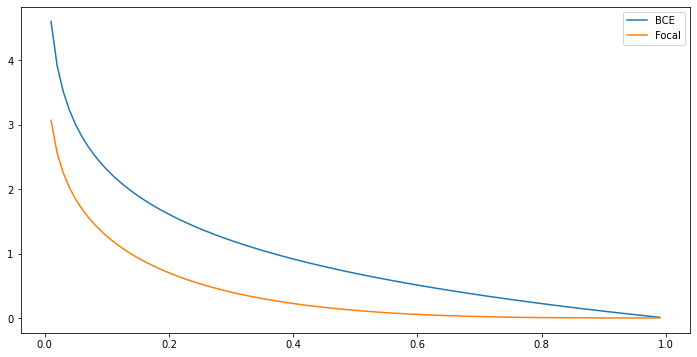

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class WeightedFocalLoss(torch.nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.66, gamma=2): 
        # Cloud cover (label==1) is ~66%
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.BCEWithLogitsLoss(reduction="none")(inputs, targets.float())
        
        at = self.alpha[targets]#.data.view(inputs.shape[0], -1)]
        
        pt = torch.exp(-BCE_loss)
        
        # print(BCE_loss.size(), at.size(), pt.size()) 
        # print(at, pt, BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()
    
n = 100
targets = torch.ones(n, dtype=torch.int64)
prob = torch.linspace(0.01,0.99,n)
inputs = torch.log(prob/(1-prob))
# inputs = prob # THIS IS A HUGE BUG!!!!!!

alpha = 0.66
gamma = 2.
alpha = torch.tensor([alpha, 1-alpha])


BCE_loss = torch.nn.BCEWithLogitsLoss(reduction="none")(inputs, targets.float())

at = alpha[targets]#.data.view(inputs.shape[0], -1)]

pt = torch.exp(-BCE_loss)

focal = at*(1-pt)**gamma * BCE_loss

plt.figure(figsize=(12,6))
plt.plot(prob, BCE_loss, label="BCE") 
plt.plot(prob, 2*focal, label="Focal")

plt.legend()


[1.00072046 1.01503496 1.02914594 1.04305771 1.05677445 1.07030025
 1.08363905 1.09679471 1.10977098 1.1225715  1.13519982 1.14765939
 1.15995356 1.17208562 1.18405874 1.19587604 1.20754052 1.21905514
 1.23042277 1.2416462  1.25272816 1.2636713  1.27447823 1.28515146
 1.29569347 1.30610666 1.31639337 1.32655589 1.33659647 1.34651728
 1.35632045 1.36600806 1.37558215 1.3850447  1.39439764 1.40364288
 1.41278225 1.42181757 1.4307506  1.43958308 1.44831668 1.45695307
 1.46549385 1.4739406  1.48229488 1.49055818 1.49873199 1.50681775
 1.51481687 1.52273075 1.53056074 1.53830817 1.54597432 1.55356049
 1.5610679  1.56849779 1.57585134 1.58312973 1.5903341  1.59746558
 1.60452526 1.61151423 1.61843354 1.62528424 1.63206733 1.6387838
 1.64543465 1.65202082 1.65854325 1.66500287 1.67140058 1.67773725
 1.68401377 1.69023099 1.69638973 1.70249083 1.70853509 1.71452329
 1.72045622 1.72633464 1.73215929 1.73793091 1.74365022 1.74931792
 1.75493472 1.76050129 1.76601832 1.77148644 1.77690632 1.78227

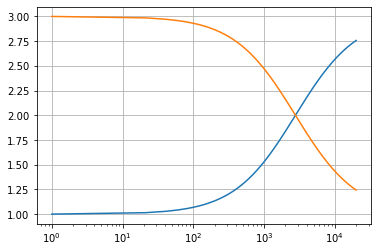

In [93]:
# weight by hard things
from cloud_seg.utils.band_normalizations import *

turnover = 1000
lumi = np.linspace(1,2e4, 1000)

lum = feder_scale(np.linspace(1,2e4, 1000))
# plt.plot(lum, np.log((lum+turnover)/turnover) + 1)
# plt.plot(lum, feder_scale(lum)+2)
# bright_land_weight =  2*(lum/2775)/((lum/2775)+0.4)+1
# dim_cloud_weight = 2-2*(lum/2775)/((lum/2775)+0.4)+1
def bright_land_weight(x):
    return x + 2

def dim_cloud_weight(x):
    return 2 - x
    
targets = 0
brightness_weight = targets * dim_cloud_weight(lum) + (1-targets) * bright_land_weight(lum) 

print(brightness_weight)
plt.plot(lumi, bright_land_weight(lum))
plt.plot(lumi, dim_cloud_weight(lum))
plt.grid()
plt.xscale('log')
# label *  + (1-label) * 

In [12]:
%%file {unet_model_dir}/metrics.py

import numpy as np
import torch
import torchmetrics

class Intersection(torchmetrics.Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)

        self.add_state("intersection", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds, target = self._input_format(preds, target)
        assert preds.shape == target.shape

        
        self.intersection += torch.logical_and(preds.view(-1), target.view(-1))
        # self.correct += torch.sum(preds == target)
        # self.total += target.numel()

    def compute(self):
        return self.intersection.float()
        # return self.correct.float() / self.total

Overwriting ../cloud_seg/models/unet/metrics.py


In [53]:
%%file {unet_model_dir}/callbacks.py

# Adapted from https://github.com/PyTorchLightning/Lightning-Bolts/blob/master/pl_bolts/callbacks/vision/confused_logit.py#L20-L167
from typing import Sequence

import torch
from pytorch_lightning import Callback, LightningModule, Trainer
from torch import Tensor, nn

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure


# from pytorch_lightning.utilities import rank_zero_only
# @rank_zero_only
class DisplayChipsCallback(Callback):  # pragma: no cover
    """Takes the input chip, true label, and label prediction
        trainer = Trainer(callbacks=[DisplayChips()])
    .. note:: Whenever called, this model will look for ``self.last_batch`` and ``self.last_logits``
              in the LightningModule.
    """

    def __init__(
        self,
        num_images_plot: int=4,
    ):
        """
        Args:
            top_k: How many  images we should plot
   
        """
        super().__init__()
        self.num_images_plot = num_images_plot

    def on_validation_epoch_end(
        self,
        trainer: Trainer,
        pl_module: LightningModule,
        # outputs: Sequence,
        # batch: Sequence,
        # batch_idx: int,
        # dataloader_idx: int,
    ) -> None:
        # show images only every 20 batches
        # if batch_idx != 0:
        #     return

        # pick the last batch and logits
        # x, y = batch["chip"], batch["label"]
        try:
            x = pl_module.last_x.to("cpu")
            y = pl_module.last_y.to("cpu")
            pred = pl_module.last_pred.to("cpu")
            
        except AttributeError as err:
            m = """please track the last_pred in the validation_step like so:
                def validation_step(...):
                    self.last_pred = your_pred
            """
            raise AttributeError(m) from err

        print(pred)
        self._plot(x, y, pred, trainer, pl_module)

    def _plot(
        self,
        x: Tensor,
        y: Tensor,
        pred: Tensor,
        trainer: Trainer,
        model: LightningModule,
    ) -> None:

        batch_size, c, w, h = x.size()

        # final batch may not be full size
        nimg_plt = self.min(batch_size, self.num_images_plot)
        
        fig, axarr = plt.subplots(nrows=nimg_plt, ncols=3, figsize=(15, 5*))
       
        for img_i in range(nimg_plt):
            xi = x[img_i].to("cpu")
            yi = y[img_i].to("cpu")
            predi = pred[img_i].to("cpu")
            
            self.__draw_data_sample(fig, axarr, img_i, 0, xi[0], "Chip")
            self.__draw_label_sample(fig, axarr, img_i, 1, yi, "True label")
            self.__draw_label_sample(fig, axarr, img_i, 2, predi, "Prediction")
            
        # model.logger.experiment.add_figure("validation_predictions", fig, global_step=trainer.global_step)
        # trainer.logger.experiment[0].add_image("validation_predictions", fig, global_step=trainer.global_step)
        # model.log("validation_predictions", fig, global_step=trainer.global_step)

    @staticmethod
    def __draw_data_sample(fig: Figure, axarr: Axes, row_idx: int, col_idx: int, img: Tensor, title: str) -> None:
        im = axarr[row_idx, col_idx].imshow(img)
        axarr[row_idx, col_idx].set_title(title, fontsize=20)
        
    @staticmethod
    def __draw_label_sample(fig: Figure, axarr: Axes, row_idx: int, col_idx: int, img: Tensor, title: str) -> None:
        im = axarr[row_idx, col_idx].imshow(img, vmin=0., vmax=1.)
        axarr[row_idx, col_idx].set_title(title, fontsize=20)
        
                

Overwriting ../cloud_seg/models/unet/callbacks.py


In [33]:
%%file {unet_model_dir}/plotting_tools.py

import numpy as np
import torch
from torch import Tensor

from matplotlib import pyplot as plt
import xarray
import xrspatial.multispectral as ms

try:
    from cloud_seg.utils.band_normalizations import feder_scale
except ImportError:
    from band_normalizations import feder_scale
    
# from pytorch_lightning.utilities import rank_zero_only
# @rank_zero_only

def to_xarray(im_arr):
    """Put images in xarray.DataArray format"""

    return xarray.DataArray(im_arr, dims=["y", "x"])

def true_color_img(img, normalized=True):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    
    band_mean_std = {'B02': {'mean': 2848.064112016446,
    'std': 3156.9268464765087,
    'min': 0,
    'max': 27600},
    'B03': {'mean': 2839.0871485290295,
    'std': 2899.280144509762,
    'min': 0,
    'max': 26096},
    'B04': {'mean': 2741.2891076425326,
    'std': 2789.961608891907,
    'min': 0,
    'max': 23104},
    'B08': {'mean': 3657.9092112857143,
    'std': 2424.18942846055,
    'min': 0,
    'max': 19568}}

    if normalized:
        img[2] = img[2]*band_mean_std['B04']['std'] + band_mean_std['B04']['mean']
        img[1] = img[1]*band_mean_std['B03']['std'] + band_mean_std['B03']['mean']
        img[0] = img[0]*band_mean_std['B02']['std'] + band_mean_std['B02']['mean']
        
    red = to_xarray(img[2])
    green = to_xarray(img[1])
    blue = to_xarray(img[0])
    
    return ms.true_color(r=red, g=green, b=blue)

def intersection_over_union(pred, true, smooth=1):
    """
    Calculates intersection over union for an image.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    # Intersection and union totals
    pred_flattened = pred.view(-1)
    true_flattened = true.view(-1)

    intersection = torch.logical_and(true_flattened, pred_flattened)
    union = torch.logical_or(true_flattened, pred_flattened)
    
    return (torch.sum(intersection).float() + smooth)/ (torch.sum(union).float() + smooth)

def plot_prediction_grid(
    x: Tensor,
    y: Tensor,
    pred: Tensor,
    chip_id,
    scale_feature_channels = None,
    num_images_plot: int = 4,
    fontsize=18):

        batch_size, c, w, h = x.size()
        
        nimg_plt = min(batch_size, num_images_plot)

        fig, axarr = plt.subplots(nrows=nimg_plt, ncols=3, figsize=(15, 5*nimg_plt))
       
        for img_i in range(nimg_plt):
            
            chip_idi = chip_id[img_i]
            
            if scale_feature_channels is None:
                xi = true_color_img(x[img_i].to("cpu").numpy().astype(np.float32), normalized=True)
                
            if scale_feature_channels == "feder_scale":
                xi = feder_scale(x[img_i], inv=True).to("cpu").numpy().astype(np.float32)
                xi = true_color_img(xi, normalized=False)
                                    
            if scale_feature_channels == "true_color":
                xi = x[img_i].to("cpu").numpy().astype(np.float32)
                xi = np.transpose(xi, [1, 2, 0]).astype(np.uint8)
            else:
                xi = x[img_i][0].to("cpu").numpy().astype(np.float32)

            yi = y[img_i].to("cpu")
            predi = pred[img_i].to("cpu")
            
            IoU = intersection_over_union(yi, predi)
            
            axarr[img_i, 0].imshow(xi)
            axarr[img_i, 0].set_title(f"{chip_idi}", fontsize=fontsize)
            
            axarr[img_i, 1].imshow(yi, vmin=0., vmax=1.)
            axarr[img_i, 1].set_title("True label", fontsize=fontsize)
            
            axarr[img_i, 2].imshow(predi, vmin=0., vmax=1.)
            axarr[img_i, 2].set_title(f"Pred: IoU={IoU:.3f}", fontsize=fontsize)
            
        plt.close(fig)
        
        return fig
                

Overwriting ../cloud_seg/models/unet/plotting_tools.py


In [6]:
%%file {unet_model_dir}/cloud_model.py

from typing import Optional, List

import pandas as pd
import pytorch_lightning as pl
import pl_bolts 
import segmentation_models_pytorch as smp
import torch
import torchmetrics

# from pytorch_lightning.utilities import rank_zero_only
# from pytorch_lightning.loggers.base import rank_zero_experiment

try:
    from .cloud_dataset import CloudDataset
    from .losses import intersection_and_union
    from .losses import dice_loss, power_jaccard, WeightedFocalLoss
    from .plotting_tools import plot_prediction_grid
    
except ImportError:
    from cloud_dataset import CloudDataset
    from losses import intersection_and_union
    from losses import dice_loss, power_jaccard, WeightedFocalLoss
    from plotting_tools import plot_prediction_grid
   
    
class CloudModel(pl.LightningModule):
    def __init__(
        self,
        bands: List[str],
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.DataFrame] = None,
        train_cloudbank: Optional[pd.DataFrame] = None,
        val_cloudbank: Optional[pd.DataFrame] = None,
        train_transforms = None,
        val_transforms = None,
        train_cloud_transforms = None,
        val_cloud_transforms = None,
        hparams: dict = {},
    ):
        """
        Instantiate the CloudModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

        Args:
            bands (list[str]): Names of the bands provided for each chip
            x_train (pd.DataFrame, optional): a dataframe of the training features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_train (pd.DataFrame, optional): a dataframe of the training labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            x_val (pd.DataFrame, optional): a dataframe of the validation features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_val (pd.DataFrame, optional): a dataframe of the validation labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            cloudbank (pd.DataFrame, optional): a dataframe of paths to additional clouds to sample from. 
                Optional for model training, but required if using chips where label_path=='None'
            hparams (dict, optional): Dictionary of additional modeling parameters.
        """
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()

        # required
        self.bands = bands
        self.num_channels = len(bands)

        # optional modeling params
        self.segmentation_model = self.hparams.get("segmentation_model", "unet")
        self.encoder_name = self.hparams.get("encoder_name", "resnet18")
        self.weights = self.hparams.get("weights", None)
        
        self.encoder_depth = self.hparams.get("encoder_depth", 5)
        self.decoder_channels = [2**(i+4) for i in range(self.encoder_depth)][::-1]
        # self.decoder_channels = [64,64,32,16,16]

        self.decoder_attention_type = self.hparams.get("decoder_attention_type", None)
        
        self.scale_feature_channels = self.hparams.get("scale_feature_channels", None)
        self.custom_features = self.hparams.get("custom_features", None)   
        if self.scale_feature_channels == "custom":
            self.num_channels = len(self.custom_features)
        
        self.loss_function = self.hparams.get("loss_function", "BCE")        
        self.optimizer = self.hparams.get("optimizer", "ADAM")
        self.scheduler = self.hparams.get("scheduler", "PLATEAU")
        
        self.learning_rate = self.hparams.get("learning_rate", 1e-3)
        self.weight_decay = self.hparams.get("weight_decay", 5e-4)
        
        self.use_npy_labels = self.hparams.get("use_npy_labels", False)

        self.momentum = self.hparams.get("momentum", 0.9)
        self.T_0 = self.hparams.get("T_0", 10)
        self.eta_min = self.hparams.get("eta_min", 1e-5)
        
        self.warmup_epochs = self.hparams.get("warmup_epochs", 10)
        self.max_epochs = self.hparams.get("max_epochs", 40)

        self.reduce_learning_rate_factor = self.hparams.get("reduce_learning_rate_factor", 0.1)

        self.patience = self.hparams.get("patience", 10)
        self.learning_rate_patience = self.hparams.get("learning_rate_patience", 5)
        self.batch_size = self.hparams.get("batch_size", 8)

        self.num_workers = self.hparams.get("num_workers", 2)
        self.pin_memory = self.hparams.get("pin_memory", True)
        self.persistent_workers = self.hparams.get("persistent_workers", False)
        
        self.gpu = self.hparams.get("gpu", False)
        
        self.log_on_epoch = self.hparams.get("log_on_epoch", True)
        self.log_on_step = self.hparams.get("log_on_step", False)
        self.progress_bar = self.hparams.get("progress_bar", False)
        
        self.plot_validation_images = self.hparams.get("plot_validation_images", True)
        self.num_images_plot = self.hparams.get("num_images_plot", self.batch_size)

        self.train_transform = train_transforms
        self.val_transform = val_transforms
        self.train_cloud_transform = train_cloud_transforms
        self.val_cloud_transform = val_cloud_transforms
       
        # Instantiate datasets, model, and trainer params if provided
        self.train_dataset = CloudDataset(
            x_paths=x_train,
            bands=self.bands,
            y_paths=y_train,
            transforms=self.train_transform,
            cloudbank=train_cloudbank,
            cloud_transforms=self.train_cloud_transform,
            scale_feature_channels=self.scale_feature_channels,
            custom_features=self.custom_features,
            use_npy_labels=self.use_npy_labels,
        )
        
        self.val_dataset = CloudDataset(
            x_paths=x_val,
            bands=self.bands,
            y_paths=y_val,
            transforms=self.val_transform,
            cloudbank=val_cloudbank,
            cloud_transforms=self.val_cloud_transform,
            scale_feature_channels=self.scale_feature_channels,
            custom_features=self.custom_features,
            use_npy_labels=False,
        )
        
        # define some performance metrics using torchmetrics
        # self.train_accuracy = torchmetrics.Accuracy()
        # self.val_intersection = mymetrics.Intersection()
        try:
            self.train_IoU = torchmetrics.JaccardIndex(num_classes=2)
            self.val_IoU = torchmetrics.JaccardIndex(num_classes=2)

            self.train_Recall = torchmetrics.Recall()#num_classes=2)#, average='samples')
            self.val_Recall = torchmetrics.Recall()#num_classes=2)#, average='samples')

            self.train_Precision = torchmetrics.Precision()#num_classes=2)#, average='samples')
            self.val_Precision = torchmetrics.Precision()#num_classes=2)#, average='samples')

            self.train_F1Score = torchmetrics.F1Score()#num_classes=2)#, average='samples')
            self.val_F1Score = torchmetrics.F1Score()#num_classes=2)#, average='samples')

            self.train_Specificity = torchmetrics.Specificity()#num_classes=2)#, average='samples')
            self.val_Specificity = torchmetrics.Specificity()#num_classes=2)#, average='samples')

        except:
            # torchmetrics changed names in recent versions
            # Train/validate wont work, but forward will
            self.val_IoU = None
            self.train_IoU = None
 
            self.train_Recall = None
            self.val_Recall = None
            
            self.train_Precision = None
            self.val_Precision = None

            self.train_F1Score = None
            self.val_F1Score = None

            self.train_Specificity = None
            self.val_Specificity = None

        self.model = self._prepare_model()
        
    def add_to_log(self, log_string, log_value):
        self.log(
            log_string, log_value,
            on_step=self.log_on_step,
            on_epoch=self.log_on_epoch,
            prog_bar=self.progress_bar,
        )
        
    ## Required LightningModule methods ##
    def forward(self, image: torch.Tensor):
        """
        Forward pass
        output of model is (B, 1, H, W), so remove axis=1
        return raw logits in order to use BCEWithLogitsLoss which is more stable than BCE:
        https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
        """
        return self.model(image).view(-1, 512, 512)

    def calculate_loss(self, x, label, preds):
        if self.loss_function.upper()=="BCE":
            loss = torch.nn.BCEWithLogitsLoss(reduction="none")(preds, label.float()).mean()
            
        elif self.loss_function.upper()=="DICE":
            loss = dice_loss(preds, label)
            
        elif self.loss_function.upper()=="JACCARD":
            loss = power_jaccard(preds, label, power_val=1.75)
            
        if self.loss_function.upper()=="FOCAL":
            loss = WeightedFocalLoss()(x, preds, label).mean()
            
        return loss

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train and y_train must be specified when CloudModel is instantiated to run training"
            )

        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        if self.loss_function.upper()=='BCE' or self.loss_function.upper()=="FOCAL":
            loss = self.calculate_loss(x, y, preds)

        else:
            preds = torch.sigmoid(preds)
            loss = self.calculate_loss(x, y, preds)
        
        # Log some tracking params
        # self.model.eval()
        # torch.set_grad_enabled(False)
   
        # preds = (preds > 0.5) * 1  # convert to int

        # batch_intersection, batch_union = intersection_and_union(preds, y)

        self.train_IoU(preds, y)
        self.train_Recall(preds, y) 
        self.train_Precision(preds, y)
        self.train_F1Score(preds, y)
        self.train_Specificity(preds, y)
        
        self.add_to_log("train_iou", self.train_IoU)
        self.add_to_log("train_Recall", self.train_Recall)
        self.add_to_log("train_Precision", self.train_Precision)
        self.add_to_log("train_F1Score", self.train_F1Score)
        self.add_to_log("train_Specificity", self.train_Specificity)
        self.add_to_log("train_loss", loss)

        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.val_dataset.data is None:
            raise ValueError(
                "x_val and y_val must be specified when CloudModel is instantiated to run validation"
            )

        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        chip_id = batch["chip_id"]
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        preds = self.forward(x)

        loss = self.calculate_loss(x, y, preds)

        preds = torch.sigmoid(preds)
        # preds = (preds > 0.5) * 1  # convert to int

        if self.plot_validation_images:
            # keep to pass to validation_epoch_end and plot
            self.last_x = x
            self.last_y = y
            self.last_pred = preds
            self.last_chip_id = chip_id

        # Log batch IOU
        # batch_intersection, batch_union = intersection_and_union(preds, y)
        self.val_IoU(preds, y)
        self.val_Recall(preds, y) 
        self.val_Precision(preds, y)
        self.val_F1Score(preds, y)
        self.val_Specificity(preds, y)
        
        self.add_to_log("val_iou", self.val_IoU)
        self.add_to_log("val_Recall", self.val_Recall)
        self.add_to_log("val_Precision", self.val_Precision)
        self.add_to_log("val_F1Score", self.val_F1Score)
        self.add_to_log("val_Specificity", self.val_Specificity)
        self.add_to_log("val_loss", loss)


        return {"loss": loss}#, "x": x, "y": y, "pred": preds}

#     def validation_step_end(self, batch_parts):
#         gpu_use = 0
#         # print(batch_parts['x'][gpu_use].size())
#         return {"x": batch_parts["x"][gpu_use], "y": batch_parts["y"][gpu_use], "pred": batch_parts["pred"][gpu_use]}

    # @rank_zero_only
    # @rank_zero_experiment
    
    def validation_epoch_end(self, outputs):
        # idevice = self.last_x.get_device()
        # if idevice == 0:
        # if self.global_rank==0:
        if self.plot_validation_images:
            # self.logger[0].experiment.add_figure("chip_label_prediction", 
            self.logger.experiment.add_figure("chip_label_prediction", 
                                                 plot_prediction_grid(
                                                     self.last_x,
                                                     self.last_y,
                                                     self.last_pred,
                                                     self.last_chip_id,
                                                     scale_feature_channels=self.scale_feature_channels,
                                                     num_images_plot=self.num_images_plot,
                                                 ),
                                              self.current_epoch,
                                             )

        # if batch_idx == 0:
            # print(out)
            # for out in validation_step_outputs[:1]:
            #     # output from each gpu
            #     print(out)
            
    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size|self.hparams.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
            persistent_workers=self.persistent_workers,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=self.plot_validation_images, # if plotting last batch images ensure full last batch
            pin_memory=self.pin_memory,
            persistent_workers=self.persistent_workers,
        )

    def configure_optimizers(self):
        
        if self.optimizer.upper()=="ADAM":
            optimizer = torch.optim.Adam(
                self.model.parameters(),
                lr=self.learning_rate,
            )
            
        if self.optimizer.upper()=="ADAMW":
            optimizer = torch.optim.AdamW(
                self.model.parameters(),
                lr=self.learning_rate,
                weight_decay=self.weight_decay,
            )
            # sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

        if self.optimizer.upper()=="SGD":
            optimizer = torch.optim.SGD(
                self.model.parameters(),
                lr=self.learning_rate,
                momentum=self.momentum,
            )
        
        if self.scheduler.upper()=="EXPONENTIAL":
            scheduler = torch.optim.lr_scheduler.ExponentialLR(
                optimizer,
                gamma=0.95,
            )
            
        if self.scheduler.upper()=="COSINE":
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            #     optimizer,
            #     T_0=self.T_0,
            #     eta_min=self.eta_min,
            # ) 

            scheduler = pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR(
                optimizer,
                warmup_epochs=self.warmup_epochs,
                max_epochs=self.max_epochs,
            ) 
  

        if self.scheduler.upper()=="PLATEAU":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                'max',
                factor=self.reduce_learning_rate_factor,
                patience=self.learning_rate_patience,
            )
            
            return {"optimizer": optimizer, 
                    "lr_scheduler": {
                        "scheduler": scheduler,
                        "monitor": "val_iou",
                    },
            }
                                       
        return [optimizer], [scheduler]
                
    ## Convenience Methods ##
    def _prepare_model(self):
        
        if self.segmentation_model.upper()=="UNET":
            # Instantiate U-Net model
            unet_model = smp.Unet(
                encoder_name=self.encoder_name,
                encoder_weights=self.weights,
                in_channels=self.num_channels,
                encoder_depth=self.encoder_depth,
                decoder_channels=self.decoder_channels,
                classes=1,
                decoder_attention_type=self.decoder_attention_type,
            )
            if self.gpu:
                unet_model.cuda()
                
        if self.segmentation_model.upper()=="DEEPLABV3PLUS":
            # Instantiate DeepLabV3Plus model (https://arxiv.org/abs/1802.02611v3)
            unet_model = smp.DeepLabV3Plus(
                encoder_name=self.encoder_name,
                encoder_weights=self.weights,
                in_channels=self.num_channels,
                classes=1,
            )
            
            if self.gpu:
                unet_model.cuda()

        return unet_model

Overwriting ../cloud_seg/models/unet/cloud_model.py


In [14]:
 [2**(i+4) for i in range(5)][::-1]

[256, 128, 64, 32, 16]

## Original training loop, with 2 output classes

In [ ]:
 def forward(self, image: torch.Tensor):
        # Forward pass
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train and y_train must be specified when CloudModel is instantiated to run training"
            )

        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Log batch loss
        loss = torch.nn.CrossEntropyLoss(reduction="none")(preds, y).mean()
        self.log(
            "loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.val_dataset.data is None:
            raise ValueError(
                "x_val and y_val must be specified when CloudModel is instantiated to run validation"
            )

        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1  # convert to int

        # Log batch IOU
        batch_iou = intersection_over_union(preds, y)
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

## Cloud model backup

In [6]:
# %%file {unet_model_dir}/cloud_model.py

from typing import Optional, List

import pandas as pd
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
import torchmetrics
# from pytorch_lightning.utilities import rank_zero_only
# from pytorch_lightning.loggers.base import rank_zero_experiment

from .cloud_dataset import CloudDataset
from .losses import intersection_and_union
from .losses import dice_loss, power_jaccard
from .plotting_tools import plot_prediction_grid


class CloudModel(pl.LightningModule):
    def __init__(
        self,
        bands: List[str],
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.DataFrame] = None,
        cloudbank: Optional[pd.DataFrame] = None,
        train_transforms = None,
        val_transforms = None,
        hparams: dict = {},
    ):
        """
        Instantiate the CloudModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

        Args:
            bands (list[str]): Names of the bands provided for each chip
            x_train (pd.DataFrame, optional): a dataframe of the training features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_train (pd.DataFrame, optional): a dataframe of the training labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            x_val (pd.DataFrame, optional): a dataframe of the validation features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_val (pd.DataFrame, optional): a dataframe of the validation labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            cloudbank (pd.DataFrame, optional): a dataframe of paths to additional clouds to sample from. 
                Optional for model training, but required if using chips where label_path=='None'
            hparams (dict, optional): Dictionary of additional modeling parameters.
        """
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()

        # required
        self.bands = bands
        self.num_channels = len(bands)
        
        # optional modeling params
        self.segmentation_model = self.hparams.get("segmentation_model", "unet")
        self.encoder_name = self.hparams.get("encoder_name", "efficientnet-b0")
        self.weights = self.hparams.get("weights", None)
        
        self.custom_feature_channels = self.hparams.get("custom_feature_channels", None)
                                                        
        self.loss_function = self.hparams.get("loss_function", "BCE")        
        self.optimizer = self.hparams.get("optimizer", "ADAM")
        self.scheduler = self.hparams.get("scheduler", "PLATEAU")
        
        self.learning_rate = self.hparams.get("learning_rate", 1e-3)
        self.momentum = self.hparams.get("momentum", 0.9)
        self.T_0 = self.hparams.get("T_0", 10)
        self.eta_min = self.hparams.get("eta_min", 1e-5)
      
        self.reduce_learning_rate_factor = self.hparams.get("reduce_learning_rate_factor", 0.1)

        self.patience = self.hparams.get("patience", 10)
        self.learning_rate_patience = self.hparams.get("learning_rate_patience", 5)
        self.batch_size = self.hparams.get("batch_size", 8)

        self.num_workers = self.hparams.get("num_workers", 2)
        self.pin_memory = self.hparams.get("pin_memory", True)
        self.persistent_workers = self.hparams.get("persistent_workers", False)
        
        self.gpu = self.hparams.get("gpu", False)
        
        self.log_on_step = self.hparams.get("log_on_step", False)
        self.progress_bar = self.hparams.get("progress_bar", False)
        
        self.plot_validation_images = self.hparams.get("plot_validation_images", True)
        self.num_images_plot = self.hparams.get("num_images_plot", self.batch_size)

        self.train_transform = train_transforms
        self.val_transform = val_transforms

        # Instantiate datasets, model, and trainer params if provided
        self.train_dataset = CloudDataset(
            x_paths=x_train,
            bands=self.bands,
            y_paths=y_train,
            cloudbank=cloudbank,
            transforms=self.train_transform,
            custom_feature_channels=self.custom_feature_channels,
        )
        self.val_dataset = CloudDataset(
            x_paths=x_val,
            bands=self.bands,
            y_paths=y_val,
            transforms=self.val_transform,
            custom_feature_channels=self.custom_feature_channels,
        )
        
        # define some performance metrics using torchmetrics
        # self.train_accuracy = torchmetrics.Accuracy()
        # self.val_intersection = mymetrics.Intersection()
        self.val_IoU = torchmetrics.IoU(num_classes=2)
        self.train_IoU = torchmetrics.IoU(num_classes=2)

        self.model = self._prepare_model()

    ## Required LightningModule methods ##
    def forward(self, image: torch.Tensor):
        """
        Forward pass
        output of model is (B, 1, H, W), so remove axis=1
        return raw logits in order to use BCEWithLogitsLoss which is more stable than BCE:
        https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
        """
        return self.model(image).view(-1, 512, 512)

    def calculate_loss(self, chip, label, preds):
        if self.loss_function.upper()=="BCE":
            loss = torch.nn.BCEWithLogitsLoss(reduction="none")(preds, label.float()).mean()
            
        if self.loss_function.upper()=="DICE":
            loss = dice_loss(preds, label)
            
        if self.loss_function.upper()=="JACCARD":
            loss = power_jaccard(preds, label, power_val=1.)

        return loss

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train and y_train must be specified when CloudModel is instantiated to run training"
            )

        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        if self.loss_function == 'BCE':
            loss = self.calculate_loss(x, y, preds)

        preds = torch.sigmoid(preds)
        
        if self.loss_function != 'BCE':
            loss = self.calculate_loss(x, y, preds)

        preds = (preds > 0.5) * 1  # convert to int

        # batch_intersection, batch_union = intersection_and_union(preds, y)
    
        self.train_IoU(preds, y)

        self.log(
            "train_performance", 
            {"iou": self.train_IoU},
            on_step=self.log_on_step,
            on_epoch=True,
            prog_bar=self.progress_bar,
        )
        self.log(
            "train_loss",
            loss,
            on_step=self.log_on_step,
            on_epoch=True,
            prog_bar=self.progress_bar,
        )
        
        # keep seperate to use for early stopping
        self.log("train_iou", self.train_IoU, on_step=True, on_epoch=True, prog_bar=self.progress_bar)

        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.val_dataset.data is None:
            raise ValueError(
                "x_val and y_val must be specified when CloudModel is instantiated to run validation"
            )

        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        chip_id = batch["chip_id"]
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        preds = self.forward(x)

        loss = self.calculate_loss(x, y, preds)

        preds = torch.sigmoid(preds)
        preds = (preds > 0.5) * 1  # convert to int

        if self.plot_validation_images:
            # keep to pass to validation_epoch_end and plot
            self.last_x = x
            self.last_y = y
            self.last_pred = preds
            self.last_chip_id = chip_id

        # Log batch IOU
        batch_intersection, batch_union = intersection_and_union(preds, y)
        self.val_IoU(preds, y)

        self.log("val_performance", 
                 {"iou": self.val_IoU},
                 on_step=self.log_on_step, on_epoch=True, prog_bar=self.progress_bar)
                 
        self.log("val_loss", loss, on_step=self.log_on_step, on_epoch=True, prog_bar=self.progress_bar)
        
        # keep seperate to use for early stopping
        self.log("val_iou", self.val_IoU, on_step=True, on_epoch=True, prog_bar=self.progress_bar)

        return {"loss": loss}#, "x": x, "y": y, "pred": preds}

#     def validation_step_end(self, batch_parts):
#         gpu_use = 0
#         # print(batch_parts['x'][gpu_use].size())
#         return {"x": batch_parts["x"][gpu_use], "y": batch_parts["y"][gpu_use], "pred": batch_parts["pred"][gpu_use]}

    # @rank_zero_only
    # @rank_zero_experiment
    
    def validation_epoch_end(self, outputs):
        # idevice = self.last_x.get_device()
        # if idevice == 0:
        # if self.global_rank==0:
        if self.plot_validation_images:
            # self.logger[0].experiment.add_figure("chip_label_prediction", 
            self.logger.experiment.add_figure("chip_label_prediction", 
                                                 plot_prediction_grid(
                                                     self.last_x,
                                                     self.last_y,
                                                     self.last_pred,
                                                     self.last_chip_id,
                                                     custom_feature_channels=self.custom_feature_channels,
                                                     num_images_plot=self.num_images_plot,
                                                 ),
                                              self.current_epoch,
                                             )

        # if batch_idx == 0:
            # print(out)
            # for out in validation_step_outputs[:1]:
            #     # output from each gpu
            #     print(out)
            
    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size|self.hparams.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
            persistent_workers=self.persistent_workers,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=self.plot_validation_images, # if plotting last batch images ensure full last batch
            pin_memory=self.pin_memory,
            persistent_workers=self.persistent_workers,
        )

    def configure_optimizers(self):
        
        if self.optimizer.upper()=="ADAM":
            optimizer = torch.optim.Adam(
                self.model.parameters(),
                lr=self.learning_rate,
            )
            
        if self.optimizer.upper()=="ADAMW":
            optimizer = torch.optim.AdamW(
                self.model.parameters(),
                lr=self.learning_rate,
            )
            # sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

        if self.optimizer.upper()=="SGD":
            optimizer = torch.optim.SGD(
                self.model.parameters(),
                lr=self.learning_rate,
                momentum=self.momentum,
            )
        
        if self.scheduler.upper()=="EXPONENTIAL":
            scheduler = torch.optim.lr_scheduler.ExponentialLR(
                optimizer,
                gamma=0.95,
            )
            
        if self.scheduler.upper()=="COSINE":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=self.T_0,
                eta_min=self.eta_min,
            ) 
  
        if self.scheduler.upper()=="PLATEAU":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                'max',
                factor=self.reduce_learning_rate_factor,
                patience=self.learning_rate_patience,
            )
            
            return {"optimizer": optimizer, 
                    "lr_scheduler": {
                        "scheduler": scheduler,
                        "monitor": "val_iou",
                    },
            }
                                       
        return [optimizer], [scheduler]
                
    ## Convenience Methods ##
    def _prepare_model(self):
        
        if self.segmentation_model.upper()=="UNET":
            # Instantiate U-Net model
            unet_model = smp.Unet(
                encoder_name=self.encoder_name,
                encoder_weights=self.weights,
                in_channels=self.num_channels,
                classes=1,
            )
            if self.gpu:
                unet_model.cuda()
                
        if self.segmentation_model.upper()=="DEEPLABV3PLUS":
            # Instantiate DeepLabV3Plus model (https://arxiv.org/abs/1802.02611v3)
            unet_model = smp.DeepLabV3Plus(
                encoder_name=self.encoder_name,
                encoder_weights=self.weights,
                in_channels=self.num_channels,
                classes=1,
            )
            if self.gpu:
                unet_model.cuda()

        return unet_model

ImportError: attempted relative import with no known parent package

In [25]:
import torch
inp = torch.randn(3)
target = torch.empty(3).random_(2)
print(inp, target)

loss = torch.nn.BCEWithLogitsLoss(reduction="none")(inp, target)
print(torch.sigmoid(inp), loss, )

tensor([1.3033, 0.8767, 0.8793]) tensor([0., 1., 1.])
tensor([0.7864, 0.7061, 0.7067]) tensor([1.5436, 0.3480, 0.3472])


In [6]:
# save the model
submission_assets_dir = submission_dir / "assets"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

NameError: name 'cloud_model' is not defined

In [32]:
# save the model
submission_assets_dir = submission_dir / "assets"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

!tree benchmark_src

# Zip submission
!cd unet_src && zip -r ../submission.zip *

!du -h submission.zip


benchmark_src
├── __pycache__
│   └── main.cpython-38.pyc
└── main.py

1 directory, 2 files


In [ ]:
# Zip submission
!cd unet_src && zip -r ../submission.zip *

In [34]:
!du -h submission.zip


84M	submission.zip
